In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from legoBlocks import *
import random
import os

DD = [] 
    
for filename in sorted(os.listdir('benchmark')):
    f = os.path.join('benchmark', filename)
    # checking if it is a file
    if os.path.isfile(f) and f.endswith('.csv'):
        d = pd.read_csv(f)
        D = {}
        D['x'] = ((d.iloc[:, 0] - d.iloc[:, 0].min()) / (d.iloc[:, 0].max() - d.iloc[:, 0].min())).to_numpy()
        D['y'] = ((d.iloc[:, 1] - d.iloc[:, 1].min()) / (d.iloc[:, 1].max() - d.iloc[:, 1].min())).to_numpy()
        D['name'] = filename
        DD.append(D)

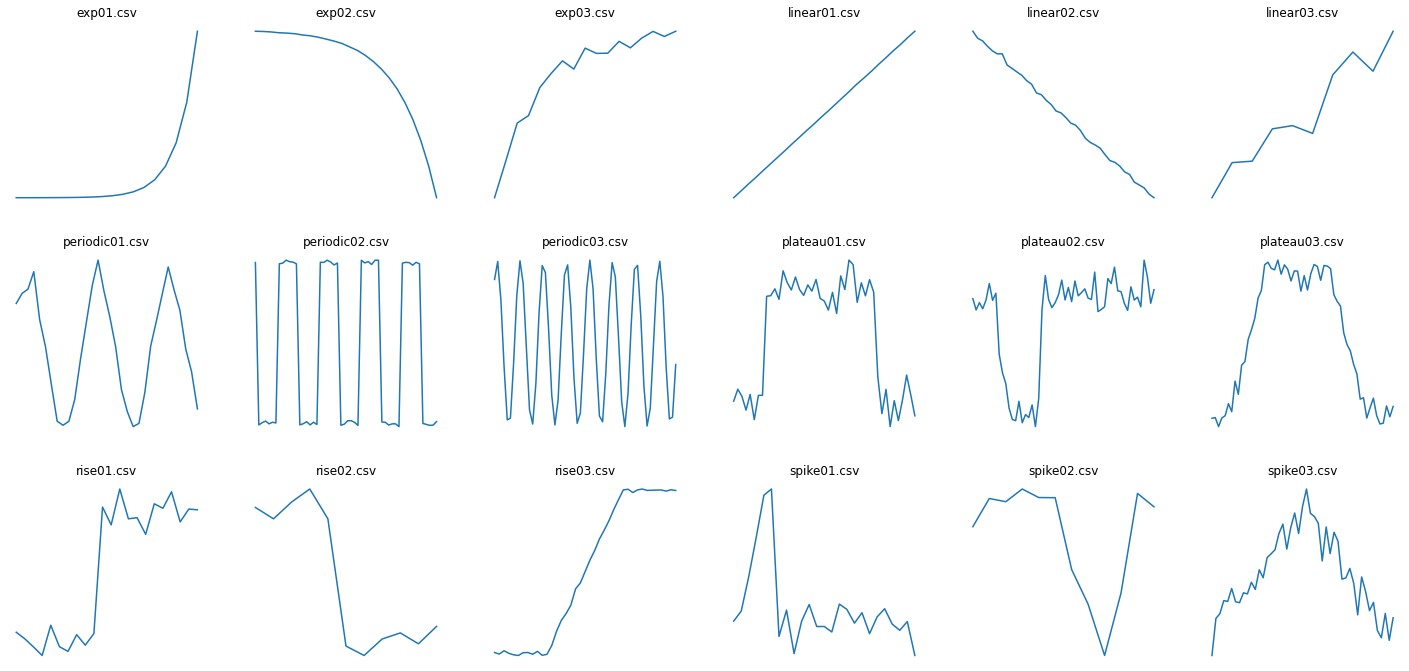

In [2]:
f = plt.figure()
f.set_figwidth(25)
f.set_figheight((int(len(DD)/6) + 1)*4)

for i in range(len(DD)):
    d = DD[i]
    dx = d['x']
    dy = d['y']
    plt.subplot(int(len(DD)/6) + 1, 6, (i+1))
    plt.title(f"{d['name']}")
    plt.plot(dx,dy)
    plt.axis('off')

plt.subplots_adjust(hspace=0.25)
plt.show()

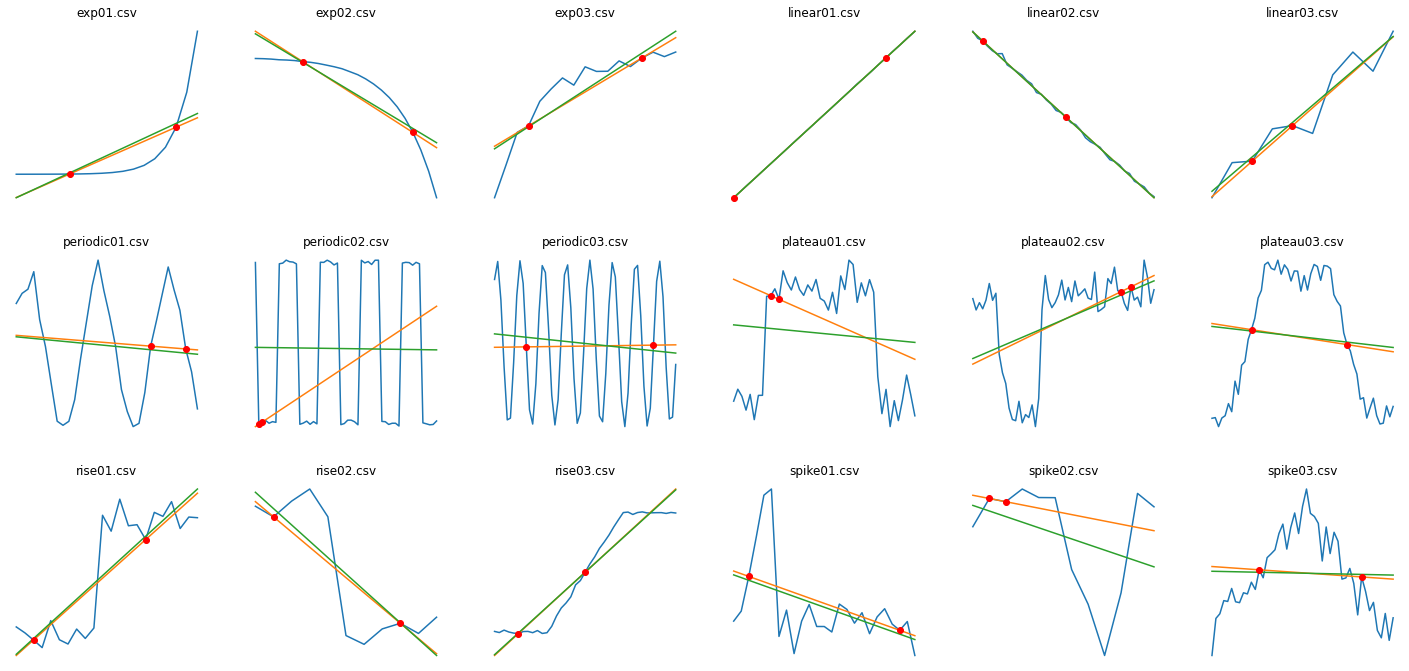

In [4]:
pipeline = Pipeline(human_proxy=H_OLS, teacher=T_OLS2,evaluator=E_MSE)
pipeline.generate_plots(DD)

In [ ]:
pipeline = Pipeline(human_proxy=H_quad, teacher=T_quad3, evaluator=E_MSE)
pipeline.generate_plots(DD)

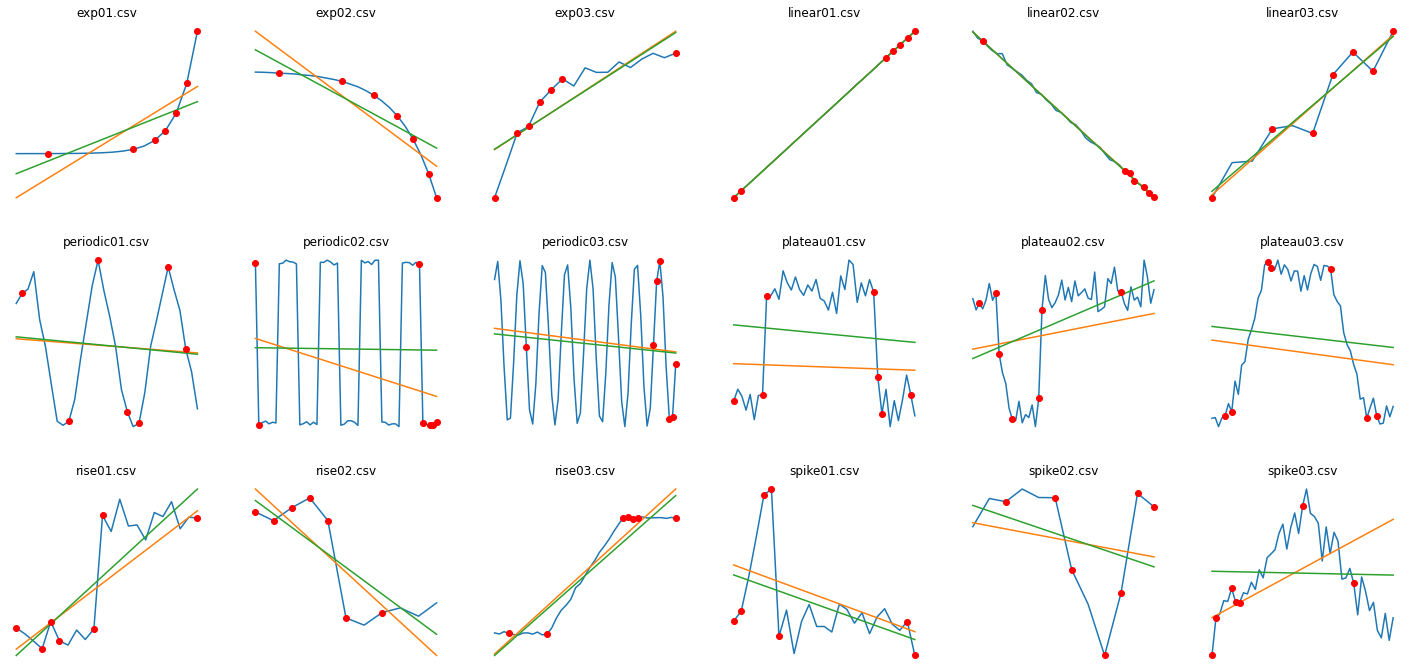

In [3]:
pipeline = Pipeline(human_proxy=H_OLS, teacher=T_PL7, evaluator=E_MSE)
pipeline.generate_plots(DD)

In [ ]:
pipeline = Pipeline(human_proxy=H_OLS, teacher=T_quad3, evaluator=E_MSE)
pipeline.generate_plots(DD)

In [ ]:
pipeline = Pipeline(human_proxy=H_OLS, teacher=T_OLS2, evaluator=E_MSE)
pipeline.generate_plots(DD)

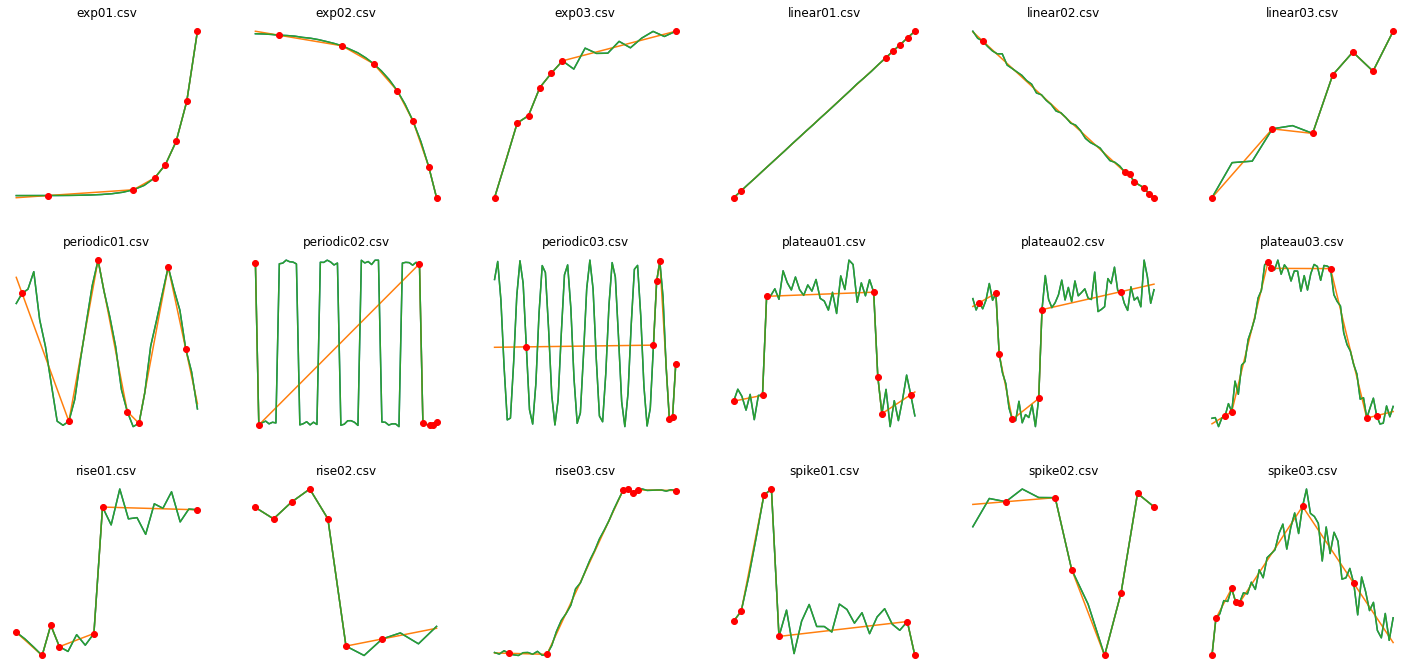

In [124]:
pipeline = Pipeline(human_proxy=H_PL, teacher=T_PL7, evaluator=E_MSE)
pipeline.generate_plots(DD)

In [ ]:
pipeline = Pipeline(human_proxy=H_PL, teacher=T_quad3, evaluator=E_MSE)
pipeline.generate_plots(DD)

In [ ]:
pipeline = Pipeline(human_proxy=H_PL, teacher=T_OLS2, evaluator=E_MSE)
pipeline.generate_plots(DD)

In [ ]:
pipeline = Pipeline(human_proxy=H_PL7, teacher=T_OLS2, evaluator=E_MSE)
pipeline.generate_plots(DD, comparison=False)

In [ ]:
pipeline = Pipeline(human_proxy=H_PL7, teacher=T_quad3, evaluator=E_MSE)
pipeline.generate_plots(DD, comparison=False)

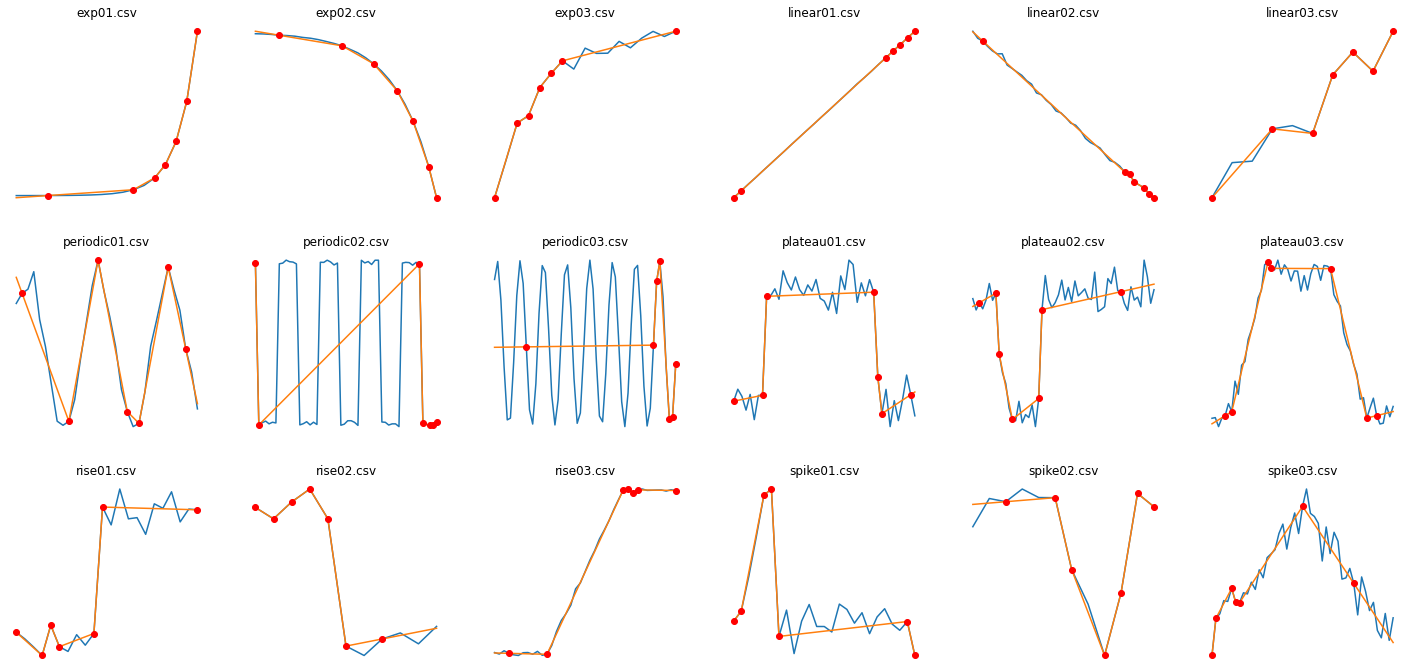

In [4]:
pipeline = Pipeline(human_proxy=H_PL7, teacher=T_PL7, evaluator=E_MSE)
pipeline.generate_plots(DD, comparison=False)

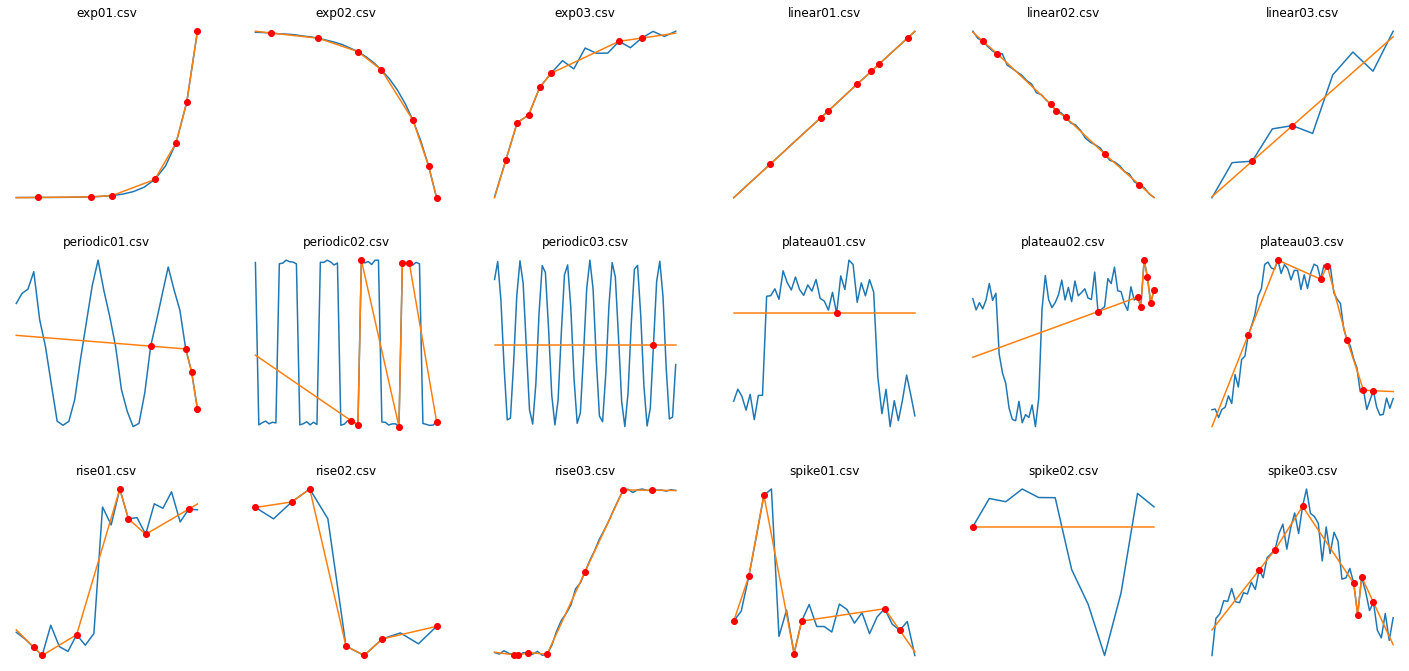

In [5]:
pipeline = Pipeline(human_proxy=H_PL7, teacher=T_GreedyConstruction, evaluator=E_MSE)
pipeline.generate_plots(DD, comparison=False)

In [18]:
def T_HillClimbing(D, H, evaluator):
    x = D['x']
    y = D['y']
    did = D['name']
    table = {}
    for i in range(len(x)):
        table[x[i]] = y[i]
        
    sample, minDist = T_GreedyConstruction(D, H, evaluator)
    x_sample = sample[0]
    y_sample = sample[1]
    x_sample_min = x_sample
    y_sample_min = y_sample
        
    x_pool = x
    for sx in range(len(x_sample)):
        x_pool = x_pool[x_pool != sx]
        
    distance = math.inf
    index = 0
    tries = 0
    while tries < 100:
        x_temp = x_sample
        y_temp = y_sample

        rng = random.random()
        x_added = -1
        x_removed = -1
        # add one element or remove one element or change one element
        if rng < 1/3 or rng > 2/3:
            x_added = x_pool[int(random.random()*len(x_pool))]
            x_pool = x_pool[x_pool != x_added]
            x_temp = np.append(x_temp, x_added)
            y_temp = np.append(y_temp, table[x_added])
        if 1/3 < rng and len(x_sample) > 2:
            x_removed = x_sample[int(random.random()*len(x_sample))]
            x_temp = np.delete(x_temp, np.argwhere(x_temp == x_removed))
            y_temp = np.delete(y_temp, np.argwhere(y_temp == table[x_removed]))
            x_pool = np.append(x_pool, x_removed)


        x_temp_sorted = [i for i,_ in sorted(zip(x_temp,y_temp))]
        y_temp_sorted = [j for _,j in sorted(zip(x_temp,y_temp))]

        human = H(x_temp_sorted, y_temp_sorted)
        distance_curr = evaluator(D, human)
        if (distance_curr < minDist):
            minDist = distance_curr
            x_sample = x_temp_sorted
            y_sample = y_temp_sorted
            tries = 0
        else:
            if x_added != -1:
                x_pool = np.append(x_pool, x_added)
            if x_removed != -1:
                x_pool = x_pool[x_pool != x_removed]
            tries += 1
    return [x_sample, y_sample], minDist

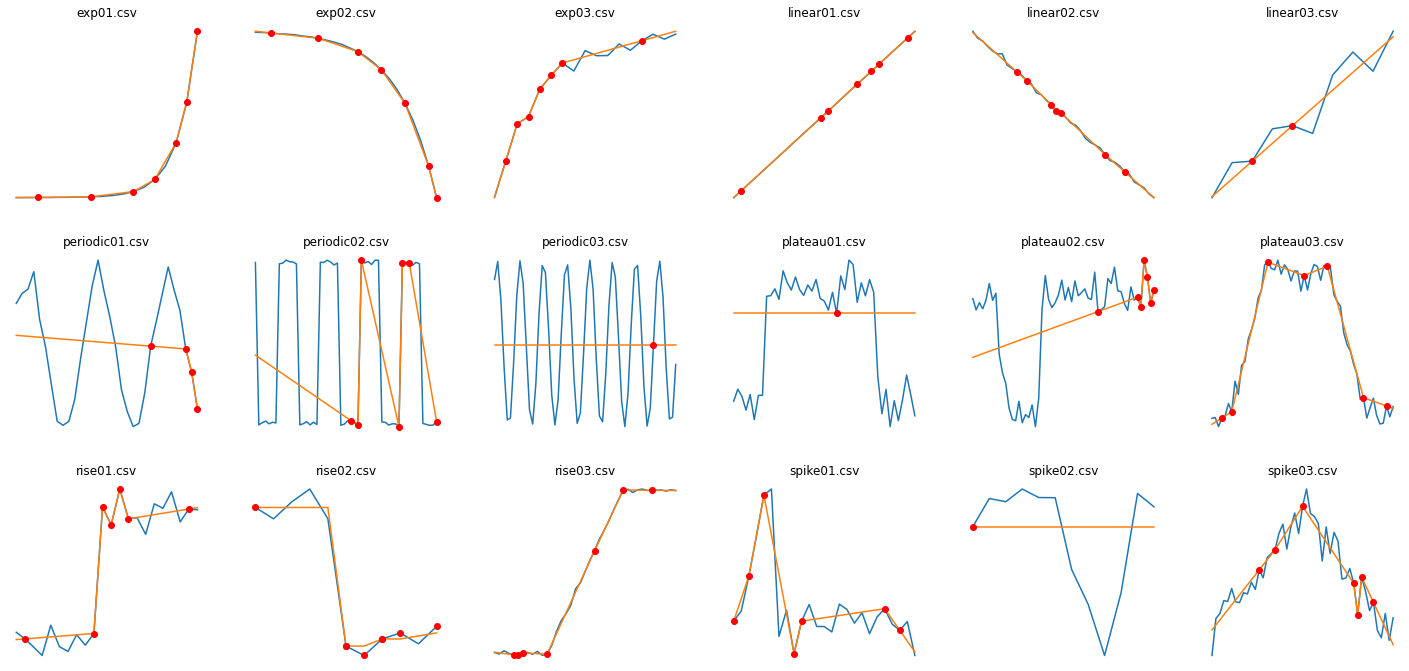

In [99]:
pipeline = Pipeline(human_proxy=H_PL7, teacher=T_HillClimbing, evaluator=E_MSE)
pipeline.generate_plots(DD, comparison=False)

In [6]:
def T_HillClimbingRestart(D, H, evaluator):
    x = D['x']
    y = D['y']
    did = D['name']
    table = {}
    for i in range(len(x)):
        table[x[i]] = y[i]
        
    x_sample_min = None
    y_sample_min = None

    minDistGlobal = math.inf
    for k in range(100):
        x_sample = []
        y_sample = []
        
        for u in range(len(x)):
            index_sample = random.sample(range(len(x)), 7)
            x_sample = x[index_sample]
            y_sample = y[index_sample]
        minDist = math.inf
        x_pool = x
        for sx in range(len(x_sample)):
            x_pool = x_pool[x_pool != sx]
        tries = 0
        while tries < 100:
            x_temp = x_sample
            y_temp = y_sample

            rng = random.random()
            x_added = -1
            x_removed = -1
            # add one element or remove one element or change one element
            if rng < 1/3 or rng > 2/3:
                x_added = x_pool[int(random.random()*len(x_pool))]
                x_pool = x_pool[x_pool != x_added]
                x_temp = np.append(x_temp, x_added)
                y_temp = np.append(y_temp, table[x_added])
            if 1/3 < rng and len(x_sample) > 2:
                x_removed = x_sample[int(random.random()*len(x_sample))]
                x_temp = np.delete(x_temp, np.argwhere(x_temp == x_removed))
                y_temp = np.delete(y_temp, np.argwhere(y_temp == table[x_removed]))
                x_pool = np.append(x_pool, x_removed)

            sample_sorted = sorted(zip(x_temp,y_temp))
            x_temp_sorted = [i for i,_ in sample_sorted]
            y_temp_sorted = [j for _,j in sample_sorted]

            human = H(x_temp_sorted, y_temp_sorted)
            distance_curr = evaluator(D, human)
            if (distance_curr < minDist):
                minDist = distance_curr
                x_sample = x_temp_sorted
                y_sample = y_temp_sorted
                tries = 0
            else:
                if x_added != -1:
                    x_pool = np.append(x_pool, x_added)
                if x_removed != -1:
                    x_pool = x_pool[x_pool != x_removed]
                tries += 1
        if minDist < minDistGlobal:
            minDistGlobal = minDist
            x_sample_min = x_sample
            y_sample_min = y_sample

    return [x_sample_min, y_sample_min], minDistGlobal

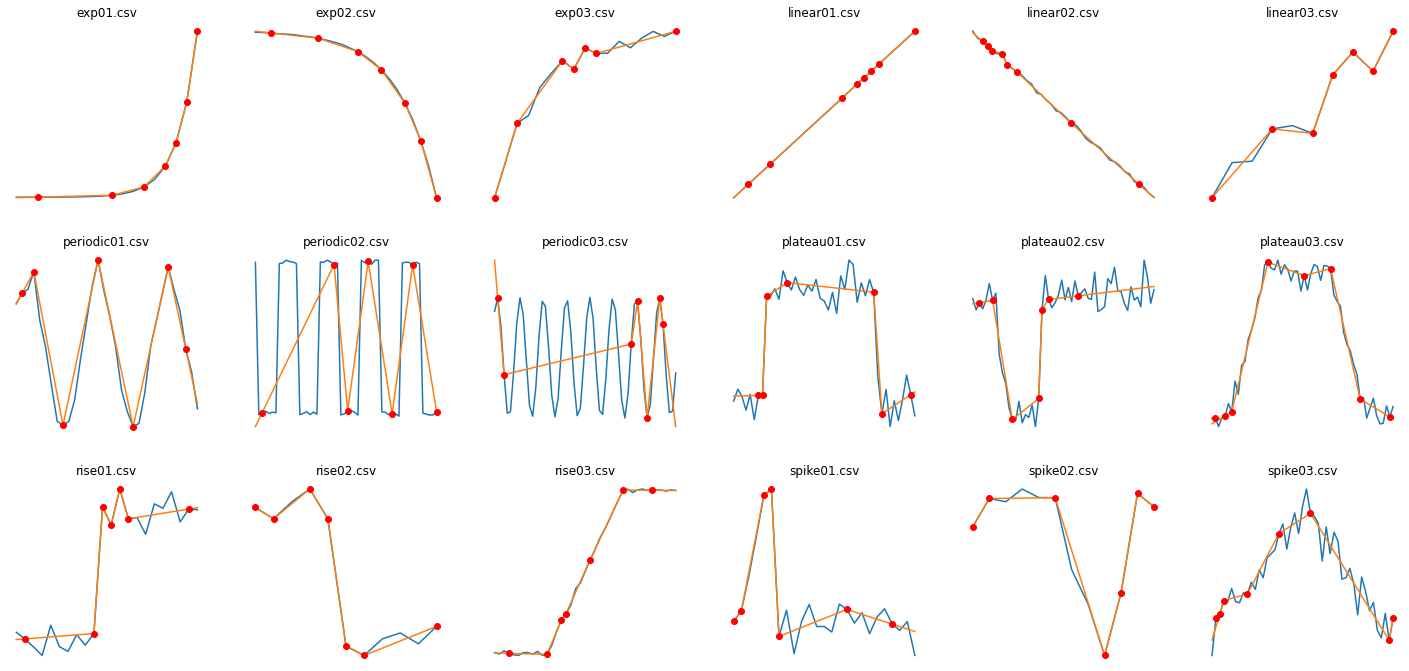

In [27]:
pipeline = Pipeline(human_proxy=H_PL7, teacher=T_HillClimbingRestart, evaluator=E_MSE)
pipeline.generate_plots(DD, comparison=False)

In [21]:
def E_extrema(D, model):
    x = D['x'].reshape(-1, 1)
    y = D['y']
    y_predicted = model.predict(x)
    return (y.max() - y_predicted.max()) ** 2 + (y.min() - y_predicted.min()) ** 2

exp01.csv: [5.934802156723613e-05, 0.00016104222252663768, 0.00033871192088394045, 0.03559698118865801, 0.10829828048111831, 0.32913943440415344, 1.0]
exp01.csv: sample_x = [0.058823529411764754, 0.1176470588235294, 0.17647058823529416, 0.6470588235294118, 0.7647058823529411, 0.8823529411764706, 1.0]
exp01.csv: sample_y = [5.934802156723613e-05, 0.00016104222252663768, 0.00033871192088394045, 0.03559698118865801, 0.10829828048111831, 0.32913943440415344, 1.0]
exp02.csv: [1.0, 0.9986221087090988, 0.9957455240561589, 0.9888715842311908, 0.9639750030937673, 0.9406293092909642, 0.0]
exp02.csv: sample_x = [0.0, 0.04347826086956525, 0.0869565217391305, 0.1739130434782609, 0.3478260869565218, 0.4347826086956522, 1.0]
exp02.csv: sample_y = [1.0, 0.9986221087090988, 0.9957455240561589, 0.9888715842311908, 0.9639750030937673, 0.9406293092909642, 0.0]
exp03.csv: [0.0, 0.9391583878955799, 0.9004955459832577, 0.958791735710448, 0.9991089061405958, 1.0]
exp03.csv: sample_x = [0.0, 0.6874999999999999

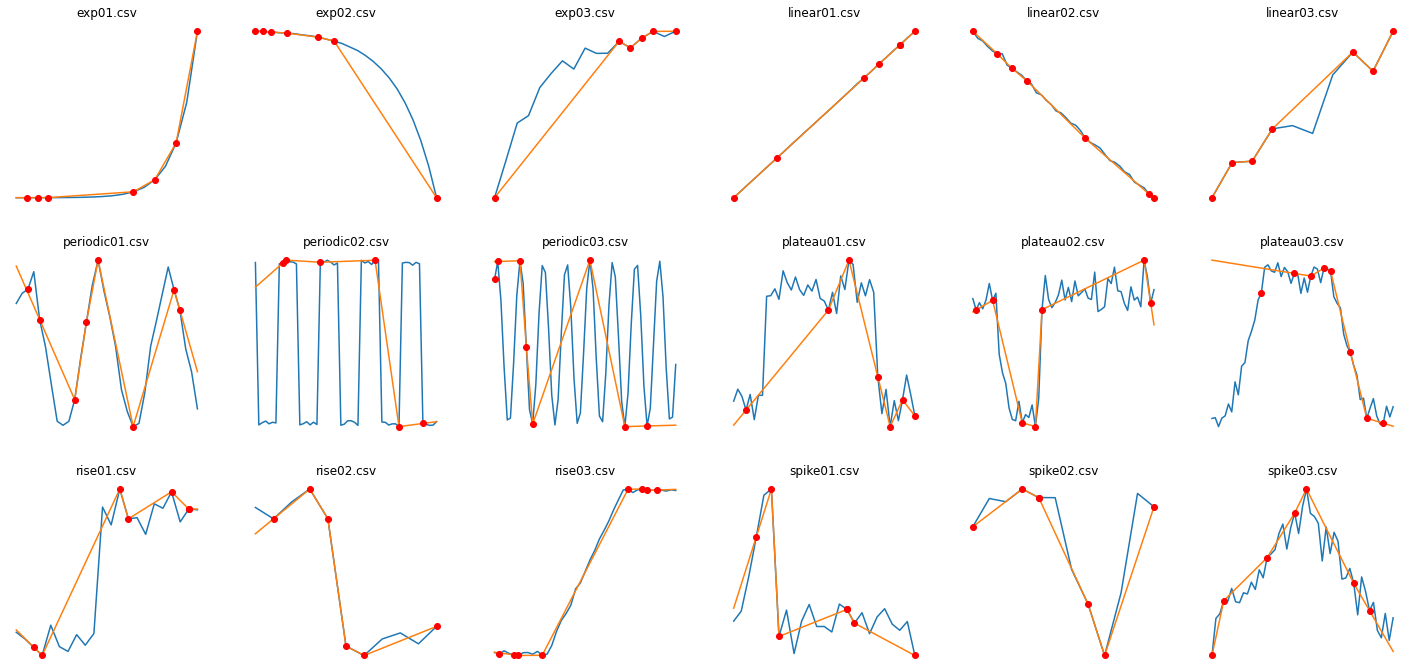

In [22]:
pipeline = Pipeline(human_proxy=H_PL7, teacher=T_HillClimbingRestart, evaluator=E_extrema)
pipeline.generate_plots(DD, comparison=False)

In [23]:
def E_MSE_extrema(D, model):
    x = D['x'].reshape(-1, 1)
    y = D['y']
    y_predicted = model.predict(x)
    return E_MSE(D, model) + 10 * ((y.max() - y_predicted.max()) ** 2 + (y.min() - y_predicted.min()) ** 2)

In [5]:
pipeline = Pipeline(human_proxy=H_PL7, teacher=T_HillClimbingRestart, evaluator=E_MSE_extrema)
pipeline.generate_plots(DD, comparison=False)

NameError: name 'T_HillClimbingRestart' is not defined

In [11]:
x = [-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]
y = [1123, 12421, 1231, 11, 12, 13, 0, 5, 0, 5]
h = H_PL7(x, y)

x = [0, 0.5, 1]
hy = h.predict(x)
print(hy)

[1, 2, 3, 4, 5, 6, 7]
[10.  10.5 11. ]
